In [26]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sys.path.append(str(Path.cwd()))
from plotting_constants import colors

root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data"

idx = pd.IndexSlice

In [2]:

year = 2035

def get_load(year, mode, carrier):
    load = pd.read_csv(root / "nodal_loads.csv", index_col=[0,1], header=list(range(9)))

    load = load.loc[idx[:,carrier], idx[:, :, :, :, str(year), mode, "static", :, :]].copy()
    load.index = load.index.get_level_values(0)
    # load.name = f"({year}, {mode}, {carrier})"

    assert load.shape[1] == 1
    load.columns = [carrier]

    return load


In [3]:
def get_gen(year, mode, carrier):

    cap = pd.read_csv(root / "nodal_capacities.csv", index_col=[0,1,2], header=list(range(9)))

    if isinstance(carrier, str):
        carrier = [carrier]
    
    cap = cap.loc[idx[:,:,carrier], idx[:,:,:,:,str(year),mode,"static",:,:]].copy()
    cap.index = cap.index.droplevel(0)
    cap = cap.unstack()
    cap.columns = carrier

    return cap.fillna(0)



In [4]:
geo = pd.read_csv(root / "nodal_geothermal_stats.csv", index_col=[0,1], header=list(range(9)))
geo.index.get_level_values(1).unique()

Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_marginal_price', 'AC_total_generation', 'dac',
       'geothermal heat chp elec', 'geothermal heat dh',
       'geothermal heat elec', 'offwind-ac', 'onwind', 'solar',
       'uch_geothermal_generation', 'uch_geothermal_generation_share',
       'uch_marginal_price', 'uch_total_generation', 'offwind-dc'],
      dtype='object')

In [5]:
geo.index.get_level_values(1).unique()

Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_marginal_price', 'AC_total_generation', 'dac',
       'geothermal heat chp elec', 'geothermal heat dh',
       'geothermal heat elec', 'offwind-ac', 'onwind', 'solar',
       'uch_geothermal_generation', 'uch_geothermal_generation_share',
       'uch_marginal_price', 'uch_total_generation', 'offwind-dc'],
      dtype='object')

In [6]:
def get_costs(year):
    fn = root.parent / "egs_costs_s_72_{}.csv".format(year)
    costs = pd.read_csv(fn).set_index("name")["capex_mean"]

    return costs

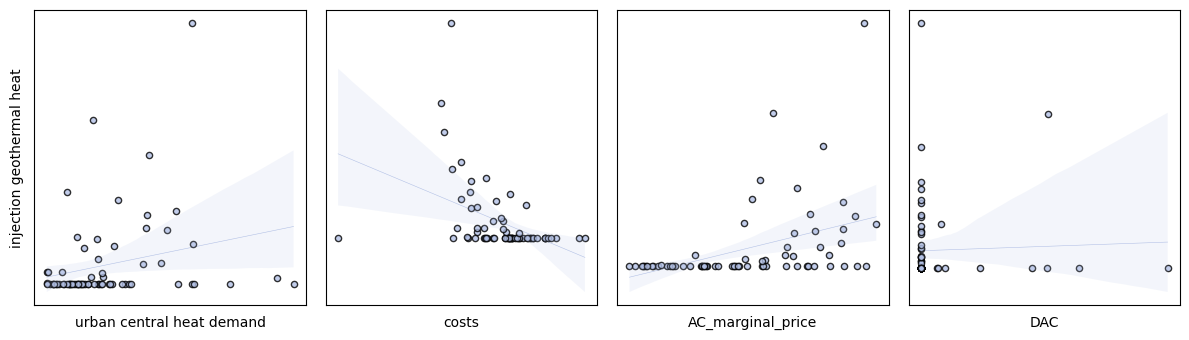

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler
geo.index.get_level_values(0).unique()

carriers = [
    "onwind",
    "offwind-ac",
    "injection geothermal heat",
    "urban central solar thermal",
    "solar",
    "solar rooftop",
    "DAC",
    "urban central water tanks charger",
    "urban central water tanks",
    "H2 Store",
    "electricity distribution grid",
]

def match_index(df, name):
    df.index = df.index.get_level_values(0)
    df.columns = [name]
    return df

years = {
    "dh": "2040",
    "chp": "2050",
    "elec": "2050",
}


def prep_data(mode, year):

    data = pd.DataFrame(index=geo.index.get_level_values(0).unique())

    data[carriers] = get_gen(year, mode, carriers)
    data["electricity demand"] = get_load(year, mode, "electricity")
    data["urban central heat demand"] = get_load(year, mode, "urban central heat")

    name = "dac_stats"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "dac"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "onwind cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "onwind"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "offwind-ac cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "offwind-ac"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "solar cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "solar"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "AC_marginal_price"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, name], idx[:, :, :, :, "2020", mode, "static", :, :]].copy(), name)

    name = "uch_marginal_price"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, name], idx[:, :, :, :, "2020", mode, "static", :, :]].copy(), name)

    # data = data.fillna(0)
    data["costs"] = get_costs(years[mode])

    data["total cp sum"] = data["onwind cp"] + data["solar cp"]    
    data["total cp mul"] = data["onwind cp"] * data["solar cp"]    

    o = StandardScaler().fit_transform(data[['onwind cp']])
    s = StandardScaler().fit_transform(data[['solar cp']])

    data["total cp manual"] = (o + s)**2

    return data


fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))

# modes = ["dh", "elec", "chp"]
modes = ["elec"]

for i, mode in enumerate(modes):

    
    data = prep_data(mode, years[mode])
    data = data.fillna(0)
    data.drop('IT1 4', inplace=True)

    # scatter_kwarg = {
    #     "s": 20,
    #     "alpha": 0.5,
    #     "edgecolor": "k"
    # }
    # data = pd.DataFrame(scaler().fit_transform(data), columns=data.columns, index=data.index)

    if mode != "elec":
        data = data.sort_values(by="injection geothermal heat", ascending=True).iloc[:-1]    

    y = MinMaxScaler().fit_transform(data[["injection geothermal heat"]])
    X = data.drop(columns=["injection geothermal heat"])

    # chosen = ["electricity demand", "urban central heat demand", "onwind cp", "solar cp"]
    # chosen = ["electricity demand", "urban central heat demand", "costs"]
    chosen = ["urban central heat demand", "costs", "AC_marginal_price", "DAC"]
    # control_for = ["urban central heat demand", "electricity demand"]

    # for col, ax in zip(X.columns, axs.flatten()):
    for i, (col, ax) in enumerate(zip(chosen, axs)):
        # ax.scatter(data[col], y.flatten(), color=colors[mode], s=20, alpha=0.8, edgecolor="k", label=col)
        # ax.legend()
        ax.set_xlabel(col)
        # ax.set_ylim(-0.05, 1.05, 2.5)

        d = pd.DataFrame({'y': y.flatten(), 'x': data[col].values})

        '''
        if i >= 2 and mode != "elec":
            from sklearn.linear_model import LinearRegression
            model = LinearRegression().fit(data[control_for], y)

            d["y"] = d["y"].values - model.predict(data[control_for]).flatten()
            d["y"] = d["y"] / d["y"].max()
        '''

        pdata = d.loc[d["y"] > 0.]

        sns.regplot(
            data=pdata, x='x', y='y', ax=ax, color=colors[mode],
            line_kws={"linewidth": 0.4, "zorder": 0},
            scatter_kws={"s": 20, "alpha": 0.8, "edgecolor": "k"}
            )

        ax.set_xlabel(col)
        ax.set_xticks([])
        ax.set_yticks([])

    

    #################################3

    '''
    scaler = StandardScaler()
    
    data = data.loc[~data["costs"].isna()]
    X = scaler.fit_transform(data[["urban central heat demand", "costs"]].values)
    y = StandardScaler().fit_transform(data[["injection geothermal heat"]])

    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF

    bounds = 1e-2
    # kernel = 1 * RBF(length_scale=1, length_scale_bounds=(bounds, bounds))
    kernel = 1 * RBF(length_scale=0.5)
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()

    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)

    model.fit(X, y)

    buffer = 0.1
    mesh_x, mesh_y = np.meshgrid(
        np.linspace(X[:,0].min() - buffer, X[:,0].max() + buffer, 50),
        np.linspace(X[:,1].min() - buffer, X[:,1].max() + buffer, 50),
    )
    X_plot = np.vstack((mesh_x.flatten(), mesh_y.flatten())).T

    y_plot = model.predict(X_plot).flatten()
    # y_plot = np.maximum(0., y_plot)

    cbar = axs[3].contourf(mesh_x, mesh_y, y_plot.reshape(mesh_x.shape), cmap="viridis")
    fig.colorbar(cbar)
    axs[3].set_xticks([])
    axs[3].set_yticks([])
    axs[3].scatter(X[:,0], X[:,1], c=y.flatten(), cmap="viridis", edgecolor="k", s=20, alpha=0.8)
    axs[3].set_ylabel("costs")
    axs[3].set_xlabel("urban central heat demand")
    ##############################
    '''


axs[0].set_ylabel("injection geothermal heat")
# for ax in axs[1:3]: ax.set_ylabel("")
# for ax in axs[:3]: ax.grid(True, linestyle="--", alpha=0.5)
for ax in axs[1:]: ax.set_ylabel("")
for ax in axs: ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [99]:
data.sort_values('DAC', ascending=False)

,onwind,offwind-ac,injection geothermal heat,urban central solar thermal,solar,solar rooftop,DAC,urban central water tanks charger,urban central water tanks,H2 Store,...,dac_stats,onwind cp,offwind-ac cp,solar cp,AC_marginal_price,uch_marginal_price,costs,total cp sum,total cp mul,total cp manual
location,,,,,,,,,,,,,,,,,,,,,
GB0 3,70555.210851,76.130836,0.118818,0.002917,85712.018617,5057.250619,771.537782,1284.440190,9.812018e+04,4.996225e+06,...,771.536586,0.388335,0.401903,0.109632,74.038866,30.542386,788.321801,0.497967,0.042574,1.269126
GB0 0,41448.147042,1019.235383,0.026564,0.002774,84470.770706,4909.177112,494.266957,1069.911609,1.405703e+05,4.628307e+06,...,494.266185,0.402822,0.423824,0.108199,78.090201,30.265323,911.041038,0.511020,0.043585,1.458682
IT1 0,2001.042785,0.001412,240248.840389,0.009613,3625.768269,8749.365793,396.067337,2794.956286,5.893908e+05,9.051759e+03,...,0.005232,0.099224,0.130201,0.148456,94.371503,38.251585,545.517233,0.247680,0.014730,0.003736
GB5 0,31733.359686,18.184481,0.005131,0.002984,12157.335698,1664.167324,393.986969,699.943153,2.692309e+04,2.082839e+06,...,393.986095,0.398051,0.478760,0.097131,64.760972,31.662900,1093.932759,0.495182,0.038663,0.478504
GB0 5,43944.040852,7.574782,0.009155,0.002746,78235.033236,10094.181171,347.006543,3170.651804,1.076097e+06,4.567988e+06,...,347.005743,0.350353,0.385394,0.109238,78.648163,34.688805,1094.173437,0.459590,0.038272,0.543969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FI2 0,26442.110917,41.114716,0.006512,0.003334,12726.469040,5123.886364,0.000791,4678.399709,3.269386e+05,5.936594e+03,...,0.000437,0.219222,0.349667,0.102194,81.290807,51.270726,1307.695270,0.321415,0.022403,0.716380
CZ1 0,403.929798,0.000000,58502.143356,0.004653,7606.254926,10364.872301,0.000742,3590.527198,3.994538e+05,4.921888e+03,...,0.000377,0.168794,0.000000,0.109912,110.212194,42.953015,994.495704,0.278706,0.018553,1.027017
SE2 1,5676.910173,0.004854,0.006371,0.003192,94.355528,793.578124,0.000714,198.625213,1.265936e+04,4.580365e+02,...,0.000359,0.196635,0.334124,0.102921,71.449097,48.747673,1126.432777,0.299556,0.020238,1.075232


In [100]:
from scipy.stats import pearsonr

rs = list()
ps = list()

for col in data.columns:
    ss = pd.concat([data["injection geothermal heat"], data[col]], axis=1).dropna()
    print(f'Share considered for col {col}:', ss.shape[0] / data.shape[0])
    r, p = pearsonr(ss.iloc[:,0], ss.iloc[:,1])
    rs.append(r)
    ps.append(p)

rs = pd.Series(rs, index=data.columns)
ps = pd.Series(ps, index=data.columns)

Share considered for col onwind: 1.0
Share considered for col offwind-ac: 1.0
Share considered for col injection geothermal heat: 1.0
Share considered for col urban central solar thermal: 1.0
Share considered for col solar: 1.0
Share considered for col solar rooftop: 1.0
Share considered for col DAC: 1.0
Share considered for col urban central water tanks charger: 1.0
Share considered for col urban central water tanks: 1.0
Share considered for col H2 Store: 1.0
Share considered for col electricity distribution grid: 1.0
Share considered for col electricity demand: 1.0
Share considered for col urban central heat demand: 1.0
Share considered for col dac_stats: 1.0
Share considered for col onwind cp: 1.0
Share considered for col offwind-ac cp: 1.0
Share considered for col solar cp: 1.0
Share considered for col AC_marginal_price: 1.0
Share considered for col uch_marginal_price: 1.0
Share considered for col costs: 1.0
Share considered for col total cp sum: 1.0
Share considered for col total 

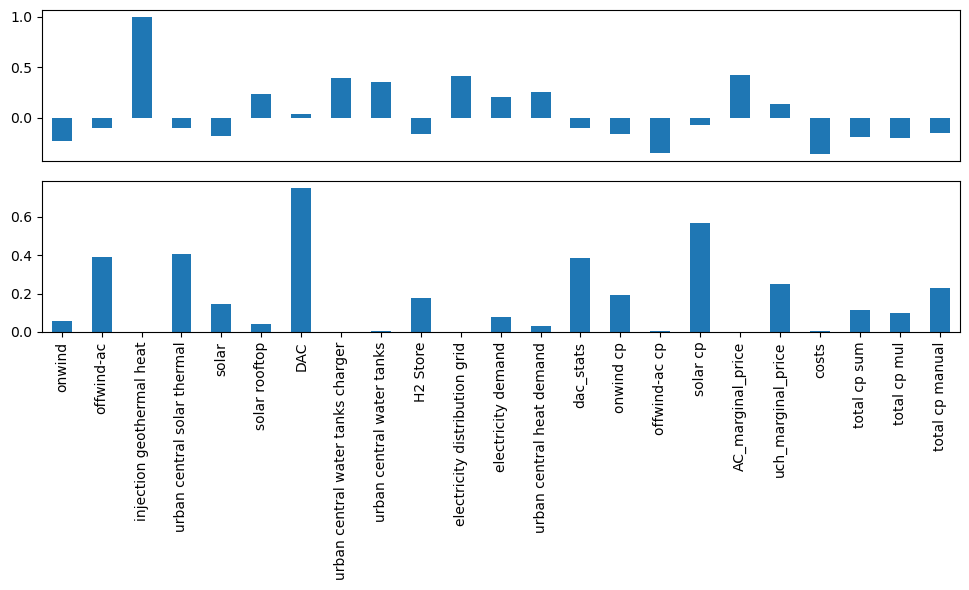

In [101]:
# sns.heatmap(data.corr())
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

rs.plot(kind="bar", ax=axs[0])
ps.plot(kind="bar", ax=axs[1])

axs[0].set_xticks([])

plt.tight_layout()
plt.show()

In [102]:
print(geo.index.get_level_values(1).unique())

geo.loc[idx[:, 'AC_marginal_price'], :]

Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_marginal_price', 'AC_total_generation', 'dac',
       'geothermal heat chp elec', 'geothermal heat dh',
       'geothermal heat elec', 'offwind-ac', 'onwind', 'solar',
       'uch_geothermal_generation', 'uch_geothermal_generation_share',
       'uch_marginal_price', 'uch_total_generation', 'offwind-dc'],
      dtype='object')


cluster                                                 72              \
ll                                                    v1.0               
opt                        Co2L0-3H-T-H-B-I-solar+p3-dist1               
planning_horizon                                      2050               
egs_capex                                             2020               
egs_mode                                               chp               
egs_op                                              static        flex   
progress                                               0.3         0.3   
use_waste_heat                                        True        True   
location                                                                 
AL1 0    AC_marginal_price                       89.273325   89.261182   
AT1 0    AC_marginal_price                      106.126913  106.137370   
BA1 0    AC_marginal_price                      101.931373  101.903400   
BE1 0    AC_marginal_price                      112.336908  112.062438   
BG1 0    AC_marginal_price                       97.392923   97.444768   
...                                                    ...         ...   
RS1 0    AC_marginal_price                       98.782946   98.792473   
SE2 0    AC_marginal_price                       72.011329   71.957630   
SE2 1    AC_marginal_price                       71.267880   71.205305   
SI1 0    AC_marginal_price                      107.079093  107.112403   
SK1 0    AC_marginal_price                      109.799534  109.777236   

cluster                                                                     \
ll                                                                           
opt                                                                          
planning_horizon                                                             
egs_capex                                                                    
egs_mode                            dh                    elec               
egs_op                          static        flex      static        flex   
progress                           0.3         0.3         0.3         0.3   
use_waste_heat                    True        True        True        True   
location                                                                     
AL1 0    AC_marginal_price   89.289539   89.233547   89.310325   89.314518   
AT1 0    AC_marginal_price  106.238848  106.469103  105.744761  105.744430   
BA1 0    AC_marginal_price  102.034472  102.014184  101.987892  101.987931   
BE1 0    AC_marginal_price  112.314677  112.007854  112.855448  112.855227   
BG1 0    AC_marginal_price   97.425746   97.444652   97.376751   97.375258   
...                                ...         ...         ...         ...   
RS1 0    AC_marginal_price   98.800040   98.865672   98.814151   98.812001   
SE2 0    AC_marginal_price   71.944014   71.673330   72.175785   72.175589   
SE2 1    AC_marginal_price   71.187402   70.875912   71.449097   71.448812   
SI1 0    AC_marginal_price  107.277228  107.415207  107.011693  107.012023   
SK1 0    AC_marginal_price  109.726832  109.888684  109.811055  109.807324   

cluster                                                                     \
ll                                                                           
opt                                                                          
planning_horizon                                                             
egs_capex                         2025                                       
egs_mode                           chp                      dh               
egs_op                          static        flex      static        flex   
progress                           0.3         0.3         0.3         0.3   
use_waste_heat                    True        True        True        True   
location                                                                     
AL1 0    AC_marginal_price

In [137]:
considered = [
    # 'onwind',
    # 'solar',
    # 'DAC',
    #'electricity distribution grid',
    'electricity demand',
    'urban central heat demand',
    'onwind cp',
    'solar cp',
    'AC_marginal_price',
    'uch_marginal_price',
    'costs',
    ]

feature_nice_names = {
    "onwind": "Onshore Wind\nCapacity",
    "solar": "Solar PV\nCapacity",
    "DAC": "Direct Air Capture\nCapacity",
    "electricity distribution grid": "Distribution Grid\nCapacity",
    "electricity demand": "Electricity\nDemand",
    "urban central heat demand": "District\nHeat Demand",
    "onwind cp": "Onshore Wind\nCapacity Factor",
    "solar cp": "Solar PV\nCapacity Factor",
    "AC_marginal_price": "Electricity\nMarginal Price",
    "total cp sum": "Sum of Wind&Solar\nCapacity Factors",
    "total cp manual": "Fct of Wind&Solar\nCapacity Factors",
    "uch_marginal_price": "District Heat\nMarginal Price",
    "costs": "Drilling Costs",
}

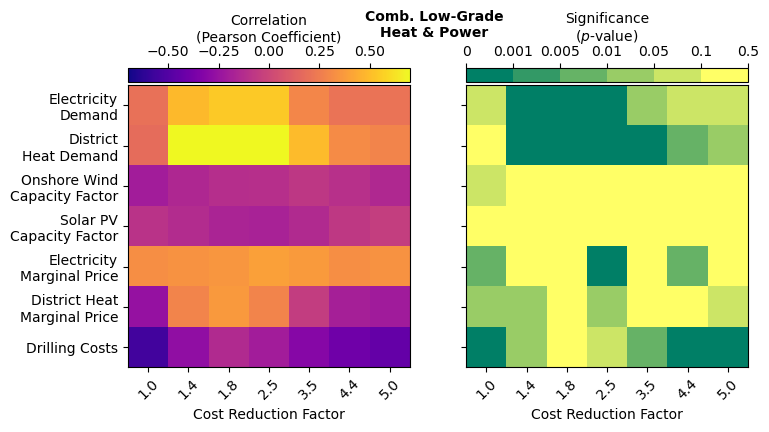

In [152]:
nice_names = {
    "elec": "Electricity\nOnly",
    "chp": "Comb. Low-Grade\nHeat & Power",
    "dh": "Low-Grade\nHeat Only",
}

import sys
sys.path.append(str(Path.cwd()))

from plotting_constants import xaxis_mapper

import matplotlib as mpl
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, IndexLocator

all_years = ["2020", "2025", "2030", "2035", "2040", "2045", "2050"]
all_modes = ["elec", "chp", "dh"]

# rs = pd.DataFrame(index=all_years, columns=all_modes)
# ps = pd.DataFrame(index=all_years, columns=all_modes)
rs = pd.DataFrame(index=all_years, columns=considered)
ps = pd.DataFrame(index=all_years, columns=considered)

feature_name = "urban central heat"
# feature_name = "electricity"
# feature_name = "cost"

vmaxs = {
    "urban central heat": 0.7,
    "electricity": 0.7,
    "cost": 0.,
}
vmins = {
    "urban central heat": 0.,
    "electricity": 0.,
    "cost": -1.,
}

cmap = "plasma"
mode = "chp"

# for year, mode in product(all_years, all_modes):
for year in all_years:

    data = prep_data(mode, year)
    data.drop('IT1 4', inplace=True)
    # for feature_name in data.columns:
    for feature_name in considered:

        '''
        if feature_name == "urban central heat" or feature_name == "electricity":
            feature = get_load(year, mode, feature_name).iloc[:,0]
        elif feature_name == "cost":
            feature = get_costs(year)
        target = get_gen(year, mode, "injection geothermal heat").iloc[:,0].loc[feature.index]
        assert (target.index == feature.index).all()
        '''

        # feature = feature.loc[~feature.isna()]
        feature = data[feature_name].dropna()
        # target = target.loc[feature.index]
        target = data['injection geothermal heat'].loc[feature.index]

        # rs.loc[year, mode], ps.loc[year, mode] = pearsonr(feature, target)
        rs.loc[year, feature_name], ps.loc[year, feature_name] = pearsonr(feature, target)

vmin = -0.7
vmax = 0.7
fig, axs = plt.subplots(1, 2, figsize=(8, 10))
cax_size = '5%'

# im0 = axs[0].imshow(rs.astype(float).T, cmap=cmap, vmin=vmins[feature_name], vmax=vmaxs[feature_name])
im0 = axs[0].imshow(rs.astype(float).T, cmap=cmap, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('top', size=cax_size, pad=0.03)
fig.colorbar(im0, cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')

cax.annotate(
    "Correlation\n(Pearson Coefficient)",
    xy=(0.5, 1.),
    xytext=(0.5, 3.8),
    xycoords="axes fraction",
    textcoords="axes fraction",
    ha="center",
    va="center",
    fontsize=10,
    color="k"
    )

ps = ps.values.astype(float).T
borders = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

for i in range(len(borders) - 1):
    ps[(ps > borders[i]) & (ps <= borders[i+1])] = i

cmap = plt.cm.summer  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 6)

im1 = axs[1].imshow(ps, cmap=cmap, vmin=0., vmax=ps.max())
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('top', size=cax_size, pad=0.03)
fig.colorbar(im1, cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')

cax.annotate(
    "Significance\n"+r"($p$-value)",
    xy=(0.5, 1.),
    xytext=(0.5, 3.8),
    xycoords="axes fraction",
    textcoords="axes fraction",
    ha="center",
    va="center",
    fontsize=10,
    color="k"
    )

cax.xaxis.set_major_locator(FixedLocator(range(len(borders))))
cax.set_xticklabels([str(b) for b in borders])

axs[1].set_yticklabels([])

# axs[0].yaxis.set_major_locator(FixedLocator(range(len(all_modes))))
axs[0].yaxis.set_major_locator(FixedLocator(range(len(considered))))
# axs[0].set_yticklabels([nice_names[m] for m in all_modes])
axs[0].set_yticklabels([feature_nice_names[col] for col in considered])

for ax in axs:
    ax.xaxis.set_major_locator(FixedLocator(range(len(all_years))))
    ax.set_xticklabels([xaxis_mapper[year] for year in all_years], rotation=45)
    ax.set_xlabel("Cost Reduction Factor")

axs[0].text(
    len(all_years)+0.1,
    -2,
    nice_names[mode],
    ha="center",
    va="center",
    fontsize=10,
    fontweight="bold",
    )

# plt.tight_layout()
plt.savefig(f"correlation_heatmap_{mode}.pdf", bbox_inches="tight")
plt.show()

In [111]:
data['t']

Index(['onwind', 'offwind-ac', 'injection geothermal heat',
       'urban central solar thermal', 'solar', 'solar rooftop', 'DAC',
       'urban central water tanks charger', 'urban central water tanks',
       'H2 Store', 'electricity distribution grid', 'electricity demand',
       'urban central heat demand', 'dac_stats', 'onwind cp', 'offwind-ac cp',
       'solar cp', 'AC_marginal_price', 'uch_marginal_price', 'costs',
       'total cp sum', 'total cp mul', 'total cp manual'],
      dtype='object')

In [144]:
data.sort_values(by="injection geothermal heat", ascending=False).head(10)

,onwind,offwind-ac,injection geothermal heat,urban central solar thermal,solar,solar rooftop,DAC,urban central water tanks charger,urban central water tanks,H2 Store,electricity distribution grid,electricity demand,urban central heat demand,dac_stats,onwind cp,offwind-ac cp,solar cp,total cp,costs
location,,,,,,,,,,,,,,,,,,,
SE2 0,13591.064153,255.775009,4856.383802,0.005827,27954.688947,8079.955808,0.001945,6424.861885,3.065122e+06,5850.937717,20613.545194,1.657596e+07,1.171491e+07,0.001313,0.235716,0.351832,0.111970,0.026393,3938.197354
DE1 1,32547.836479,0.000000,3187.910900,0.005080,81922.980002,14522.065307,0.002518,4216.724775,1.288727e+06,10694.441636,26697.543985,1.213250e+07,6.895484e+06,0.002121,0.226675,0.000000,0.106118,0.024054,2117.440332
PL1 1,65789.606951,0.000000,3010.845107,0.005701,32943.878084,23323.605281,0.002073,9888.053829,1.154196e+06,12810.817103,28327.492861,1.666927e+07,1.090695e+07,0.001520,0.228642,0.000000,0.107394,0.024555,3393.021737
AT1 0,30045.945319,0.000000,2782.871012,0.006604,83032.799783,8630.551953,33.471472,1524.532455,1.414294e+05,16795.094733,16174.659991,1.206099e+07,4.841844e+06,33.471061,0.130349,0.000000,0.120172,0.015664,1978.614086
HU1 0,37430.961131,0.000000,2755.131794,0.006784,9550.366065,9865.204459,0.007031,3262.882929,3.859489e+05,9598.956860,10040.010072,5.867197e+06,4.726418e+06,0.006375,0.155681,0.000000,0.130493,0.020315,2478.009362
DE1 7,35141.986439,0.000000,2343.996966,0.005303,60566.753645,10509.608208,0.002340,2965.896023,5.619982e+05,6853.155311,16218.208661,1.202176e+07,4.763305e+06,0.001909,0.174174,0.000000,0.110108,0.019178,2491.456388
IT1 0,12439.681684,0.002643,2076.337509,0.010006,98885.102678,8749.366959,669.129081,1407.921226,1.405687e+05,28867.155355,14317.973323,1.143180e+07,2.174424e+06,669.127825,0.099224,0.130201,0.148456,0.014730,1932.822193
CH1 0,87.909057,0.000000,1989.745079,0.008598,82481.676669,7768.183770,161.821717,890.732201,1.409856e+05,3879.356682,10883.657760,9.660930e+06,3.398739e+06,161.821317,0.041300,0.000000,0.122350,0.005053,2132.872313
NO2 0,2092.071093,0.057599,1790.253152,0.006199,8588.581246,4161.457426,601.705506,1180.208226,3.244349e+04,2231.150217,20452.454553,2.703845e+07,1.477900e+06,601.705033,0.182295,0.336750,0.088496,0.016132,2438.115927


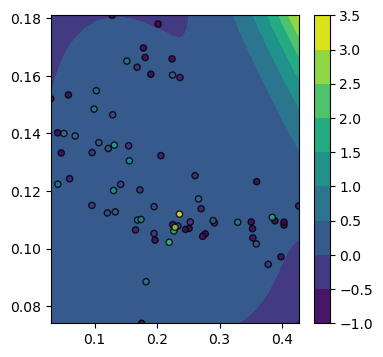

In [105]:
# plt.scatter(data["onwind cp"], data["solar cp"], c=y, cmap="viridis", s=20, alpha=0.8, edgecolor="k")
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import PolynomialFeatures

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# ax.scatter(data["onwind cp"], data["solar cp"], c=y, cmap="viridis", s=20, alpha=0.8, edgecolor="k")

X = data[["onwind cp", "solar cp"]].values

bounds = 8e-3
kernel = 1 * RBF(length_scale=0.1, length_scale_bounds=(bounds, bounds))
# model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
# model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
# model = DecisionTreeRegressor()
# model = LogisticRegression()
model = LinearRegression()

poly = PolynomialFeatures(degree=4)
poly_X = poly.fit_transform(X)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

model.fit(poly_X, y)

mesh_x, mesh_y = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 50),
    np.linspace(X[:,1].min(), X[:,1].max(), 50),
)
X_plot = np.vstack((mesh_x.flatten(), mesh_y.flatten())).T

y_plot = model.predict(poly.transform(X_plot))
# y_plot = np.maximum(0., y_plot)

cbar = ax.contourf(mesh_x, mesh_y, y_plot.reshape(mesh_x.shape), cmap="viridis")

fig.colorbar(cbar)
ax.scatter(X[:,0], X[:,1], c=y.flatten(), cmap="viridis", edgecolor="k", s=20, alpha=0.8)

# ax.set_xlim(0, 0.5)
# ax.set_ylim(0.07, 0.2)

plt.show()

In [82]:
geo = pd.read_csv(root / "nodal_geothermal_stats.csv", index_col=[0,1], header=list(range(9)))
# print(geo.head())
print(geo.index.get_level_values(0).unique())
print(geo.index.get_level_values(1).unique())

# print(geo.loc[idx["FR1 7", "uch_geothermal_generation",:], :].iloc[:,:3])
# print(geo.loc[idx["FR1 7", "uch_geothermal_generation_share",:], :].iloc[:,:3])

gen = geo.loc[idx[:, "uch_geothermal_generation",:], :].values
share = geo.loc[idx[:, "uch_geothermal_generation_share",:], :].values

index = geo.loc[idx[:, "uch_geothermal_generation",:], :].index.get_level_values(0)

# (s / a)**(-1) - a
heat_demand = (share / gen)**(-1) - gen
heat_demand = pd.DataFrame(heat_demand, index=index, columns=geo.columns)

# print(heat_demand.mean())
print(heat_demand.loc[:,idx[:,:,:,:,:,"dh","static"]].mean(axis=1))
print(heat_demand.loc[:,idx[:,:,:,:,:,"dh","static"]].std(axis=1))


Index(['AL1 0', 'AT1 0', 'BA1 0', 'BE1 0', 'BG1 0', 'CH1 0', 'CZ1 0', 'DE1 0',
       'DE1 1', 'DE1 2', 'DE1 3', 'DE1 4', 'DE1 5', 'DE1 6', 'DE1 7', 'DE1 8',
       'DE1 9', 'DK1 0', 'DK2 0', 'EE6 0', 'ES1 0', 'ES1 1', 'ES1 2', 'ES1 3',
       'ES4 0', 'FI2 0', 'FR1 0', 'FR1 1', 'FR1 2', 'FR1 3', 'FR1 4', 'FR1 5',
       'FR1 6', 'FR1 7', 'FR1 8', 'FR1 9', 'GB0 0', 'GB0 1', 'GB0 2', 'GB0 3',
       'GB0 4', 'GB0 5', 'GB5 0', 'GR1 0', 'HR1 0', 'HU1 0', 'IE5 0', 'IT1 0',
       'IT1 1', 'IT1 2', 'IT1 3', 'IT1 4', 'IT1 5', 'IT3 0', 'LT6 0', 'LU1 0',
       'LV6 0', 'ME1 0', 'MK1 0', 'NL1 0', 'NL1 1', 'NO2 0', 'NO2 1', 'PL1 0',
       'PL1 1', 'PT1 0', 'RO1 0', 'RS1 0', 'SE2 0', 'SE2 1', 'SI1 0', 'SK1 0'],
      dtype='object', name='location')
Index(['AC_geothermal_generation', 'AC_geothermal_generation_share',
       'AC_total_generation', 'dac', 'geothermal heat chp elec',
       'geothermal heat dh', 'geothermal heat elec', 'offwind-ac', 'onwind',
       'solar', 'uch_geothermal_genera

C:\Users\lukas\AppData\Local\Temp\ipykernel_15832\3930332230.py:15: RuntimeWarning: invalid value encountered in divide
  heat_demand = (share / gen)**(-1) - gen


In [47]:
share.shape

(72, 78)

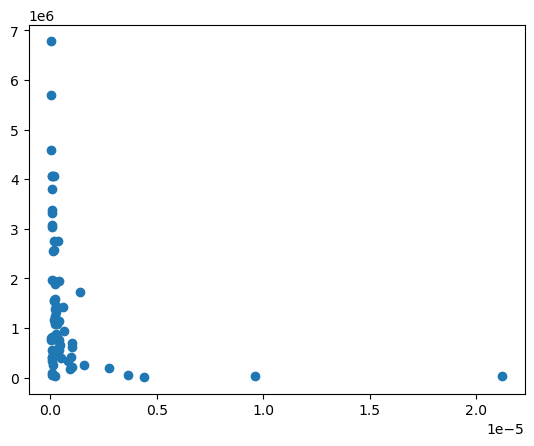

In [53]:
n = 30
gfgf = heat_demand.loc[:,idx[:,:,:,:,:,"dh","static"]].std(axis=1)
# plt.scatter(share[:,20], heat_demand.values[:,20])
plt.scatter(share[:,20], gfgf)

In [14]:
pd.read_csv(root / "nodal_costs.csv", index_col=[0,1,2,3], header=list(range(9)))

cluster                                                                                        72  \
ll                                                                                           v1.0   
opt                                                               Co2L0-3H-T-H-B-I-solar+p3-dist1   
planning_horizon                                                                             2050   
egs_capex                                                                                    1990   
egs_mode                                                                                      chp   
egs_op                                                                                     static   
progress                                                                                      0.3   
use_waste_heat                                                                               True   
generators capital  NaN   gas                                                            0.000000   
                          oil                                                            0.000000   
                    AL1 0 offwind-ac                                                   239.160990   
                          onwind                                                       262.514562   
                          residential rural solar thermal                              158.821070   
...                                                                                           ...   
stores     marginal SK1 0 residential rural water tanks                               -924.120222   
                          residential urban decentral water tanks                     -703.292645   
                          services rural water tanks                                  -530.008576   
                          services urban decentral water tanks                        -364.363509   
                          urban central water tanks                                  -1698.568311   

cluster                                                                         \
ll                                                                               
opt                                                                              
planning_horizon                                                                 
egs_capex                                                                        
egs_mode                                                                         
egs_op                                                                    flex   
progress                                                                   0.3   
use_waste_heat                                                            True   
generators capital  NaN   gas                                         0.000000   
                          oil                                         0.000000   
                    AL1 0 offwind-ac                                131.919445   
                          onwind                                    160.622954   
                          residential rural solar thermal            99.207798   
...                                                                        ...   
stores     marginal SK1 0 residential rural water tanks           -1080.575558   
                          residential urban decentral water tanks  -693.169564   
                          services rural water tanks               -501.518006   
                          services urban decentral water tanks     -345.300309   
                          urban central water tanks               -1654.905863   

cluster                                                                         \
ll                                                                               
opt                                                                              
planning_horizon                                                                 
egs_capex 

In [25]:
a = 3
b = 5
s = a/(a+b)

print(s)

0.375


In [57]:
import os
import pypsa
import numpy as np
import pandas as pd 

from pathlib import Path

root = Path.cwd().parent.parent.parent / "cluster_data" / "dump"

os.listdir(root)

n = pypsa.Network(root / "elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2020_elec_static_0.3_True.nc")

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2020_elec_static_0.3_True.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [77]:
n.loads.carrier.unique()

array(['electricity', 'land transport EV', 'land transport fuel cell',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'shipping methanol',
       'shipping methanol emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions'], dtype=object)

In [80]:
buses = n.buses.location.unique()[:-1]
loads = pd.DataFrame(index=buses)

i = 'low-temperature heat for industry'

# for carrier in :
for carrier in ["electricity", "urban central heat"]:
    print(carrier)
    index = n.loads[n.loads.carrier == carrier].index
    carrier_loads = n.loads_t.p_set[index.intersection(n.loads_t.p_set.columns)].sum()
    carrier_loads.index = carrier_loads.index.str[:5]
    carrier_loads = pd.DataFrame(carrier_loads, columns=[carrier])

    loads = pd.concat([loads, carrier_loads], axis=1)

loads.stack()

electricity
urban central heat


AL1 0  electricity            12431.106667
       urban central heat      2055.391108
AT1 0  electricity           202225.881414
       urban central heat     81539.403937
BA1 0  electricity            46911.116559
                                 ...      
SE2 1  urban central heat       431.191090
SI1 0  electricity            27799.795546
       urban central heat     12207.833963
SK1 0  electricity            70446.898765
       urban central heat     40783.127594
Length: 143, dtype: float64

In [68]:
n.loads.carrier.unique()

array(['electricity', 'land transport EV', 'land transport fuel cell',
       'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'shipping methanol',
       'shipping methanol emissions', 'naphtha for industry',
       'kerosene for aviation', 'oil emissions',
       'low-temperature heat for industry', 'industry electricity',
       'process emissions'], dtype=object)